# MNIST Digit Classification with TensorFlow

Richard Corrado <richcorrado@gmail.com> March 2017

An introduction to the MNIST digit database and the classification problem using Random Forests can be found in the notebook MNIST_Digits-overview.ipynb at <https://github.com/richcorrado/MNIST-digits>. A readable html version is at <https://richcorrado.github.io/MNIST_Digits-overview.html>.   Our results there, which we'll consider baseline results for the purposes of this notebook were:
<table align="left">
<tr><th>Model</th><th>Accuracy</th></tr>
<tr><td>Random Forest</td><td>0.964</td></tr>
<tr><td>Random Forest (drop zero padding)</td><td>0.983</td></tr>
</table>
<br><br><br><br><br>

In this notebook, we'll be using TensorFlow to apply neural networks to the MNIST digits. In particular, we'll learn:

1. How to use scikit-learn to perform a one-hot encoding of ordinal class labels, suitable for "one vs all" multiclass classification.

2. How to use scikit-learn functions to standardize features, including the case where we want to preserve some sparsity of features.

3. What the TensorFlow Computational Graph framework is and what classes are introduced by TensorFlow to implement it.

4. How to build a TensorFlow Session by organizing TensorFlow classes to specify the graph, parameters, cost function, optimizer.

5. How to run the TensorFlow session to train the model, compute metrics and make predictions.

We're going to be using the same datasets (saved as csv in an "input" directory) and validation splits, so we'll steal the code from the overview notebook to set everything up. We'll also import the other libraries that were used in that notebook that we'll also be using here.  We will make an effort to import and explain new tools as we need them.

N.B. This notebook should run in 8GB of RAM.  If you have less than that, you will probably have to adjust the code for the convolutional neural network to compute even less features.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.precision',5)
pd.set_option('display.max_colwidth',100)

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from time import time
import scipy

Load dataset.  Again, we'll only be using the kaggle train dataset in this notebook.

In [2]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")

These are the list of zero variation features.  We probably won't use them in this notebook, but they are included so that you can utilize them in your own explorations.

In [3]:
zero_cols = list(set(train_df.columns[(train_df == 0).all()].tolist() + test_df.columns[(test_df == 0).all()].tolist()))
len(zero_cols)

94

We generate the same (using random seeds) training, validation and tuning sets as in the overview notebook.

In [4]:
y_train = train_df['label'].values
x_train = train_df.drop(['label'], axis=1).values

In [5]:
validation_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=46)

training_idx, validation_idx = list(validation_split.split(x_train, y_train))[0]

training_df = train_df.iloc[training_idx]
validation_df = train_df.iloc[validation_idx]

x_training = training_df.drop(['label'], axis=1).values
y_training = training_df['label'].values

x_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label'].values

In [6]:
tuning_split = StratifiedShuffleSplit(n_splits=1, train_size=0.15, random_state=96)

tune_idx = list(tuning_split.split(x_training, y_training))[0][0]

x_tune = x_training[tune_idx]
y_tune = y_training[tune_idx]

### One-hot Encoding of the Class Labels

In this dataset, the class labels are encoded as integers 0-9.  This posed no difficulty, as many scikit-learn classification models are designed to properly treat the multiclass problem using this type of encoding.  However, TensorFlow (TF) is designed to allow very low-level design of models. Therefore, it is necessary to provide the framework to treat multiclass classification as part of the TF computation graph.   

In preparation for this, we will encode the class labels as 10d vectors rather than as integers,

$$ 0 \longrightarrow \begin{pmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix},
 1 \longrightarrow \begin{pmatrix} 0 \\ 1 \\ \vdots  \\ 0 \end{pmatrix}, \ldots
  9 \longrightarrow \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{pmatrix}.$$
  
This is sometimes called "one hot" encoding, since the presence of a defining class is indicated by a binary 1 in a vector and is analogous to the implementation of binary logic in circuits.  In the context of classification, this scheme is called "one vs all" classification and is fairly easy to implement  as an additional layer of our model in TF.  In scikit-learn, one vs all is already build into the multiclassification models so that the end user does not have to perform this additional step.

N.B. If you have already seen one hot encoding of categorical features, you might notice that our encoding here is a reducible representation of the class labels.  That is, we have 10 class labels and we could actually encode them using 9 bits by assigning one of the classes to the 0....0 representative. Such an irreducible representation is preferred for the levels of a categorical feature, but not for a class label.  This is because, if we use the reducible representation here, we can easily apply an argmax function to an output vector to determine the class.  If we had used the irreducible representation, we'd need an extra step to map an output vector matching 0...0 to the last class.  This is an unnecessary complication, so we just use the reducible representation.

To accomplish this encoding easily, we can use the OneHotEncoder or LabelBinarizer from scikit-learn. Since we are dealing with class labels, we will use LabelBinarizer.  This uses the fit, then predict/transform, methods common to the scikit-learn functions.

In [7]:
from sklearn.preprocessing import LabelBinarizer

In [8]:
lb = LabelBinarizer()

In [9]:
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

We can see explictly how the labels are transformed by applying the transformation to:

In [10]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

whose elements are mapped to 

In [11]:
lb.transform(range(10))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

which can be compared to the equations written above.

We apply the transformation to all of our response vectors:

In [12]:
y_train = lb.transform(y_train)
y_training = lb.transform(y_training)
y_validation = lb.transform(y_validation)
y_tune = lb.transform(y_tune)

### Standardizing the Data

We'll be using neural networks in this notebook.  Since the connections between layers of a neural network are made via linear models (with weights as slopes and biases as intercepts) and the weights are typically determined through some version of gradient descent, we will want to standardize our data in some way. 

Let's briefly see why we'd want to do this in a case where we have two features $x_1, x_2$ and a response $y$. Suppose also that we are using the residual sum of squares as our cost function.  So our learning algorithm will be attempting to minimize

$$ J(w,b) = \sum | w_1 x_1 + w_2 x_2 + b - y |^2,$$

where the sum is over the rows of our training data. In gradient descent, which is typically used as part of a backpropagation algorithm, we will be computing the derivatives

$$ \frac{\partial J}{\partial w_i} = 2 \sum x_i (w_1 x_1 + w_2 x_2 + b - y).$$

If the range of $x_1$ and $x_2$ are very different, then the corresponding derivatives will also range over very different values, owing to the factor of $x_i$.  For example, if our model was about house prices, $x_1$ could be the living area, with typical value 2000 sq ft, while $x_2$ is the number of bedrooms, which might be 2 or 3 in most cases.

In this example $\partial J/\partial x_1$ will typically be 1000 times as large as $\partial J/\partial x_2$  and this might, in the best case, mean that gradient descent takes much longer to converge.  In a more complicated example, in the worst case, since activation functions destroy convexivity, gradient descent might get stuck at a poor local minimum.

For these reasons, it is a good practice to standardize the features in some way so that their range of variation is similar.  There are various ways of doing this.  For example, in statistics when we say that variables have been standardized, we usually mean the z-score,

$$ z = \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation, respectively, over the measured values of $x$.  This has the obvious advantages that the mean of the new variable $\bar{z} = 0$ and standard deviation $\sigma_z = 1$.  In scikit-learn, the function for applying this transformation is found in the preprocessing kit and called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a>.

Another type of standardization is to scale the data to a given range, by using the max and min values of the unscaled data. We can first scale to the range $[0,1]$ via

$$ x_\text{std} = \frac{ x - x_\text{min} }{ x_\text{max} - x_\text{min} }, $$

then to the range $[a,b]$ via

$$ x_\text{scaled} = \frac{ x_\text{std} }{b -a  } + a. $$

The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a>.

We can also rescale data to the range $[-1,1]$ by dividing by the maximal absolute value in the unscaled data,

$$ x_\text{scaled} = \frac{ x }{ \text{max}( |x_\text{min}|,|x_\text{max}|)} $$

This transformation has the advantage that sparse data remains sparse, i.e., if $x=0$, then $x_\text{scaled} =0$.  By contrast, the z-score sends values $x = 0$ to $z=-\mu$, destroying sparsity. The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html">MaxAbsScaler</a>.

The MNIST data is relatively sparse, since 80% of the pixels are blank, so it is a good idea to use a rescaling that preserves the sparseness.  Since the pixel intensities are always nonnegative, it really doesn't matter whether we use MinMaxScaler or MaxAbsScaler, but we'll use MaxAbsScaler to emphasize that it preserves sparsity in the general case.

In [13]:
from sklearn.preprocessing import MaxAbsScaler

The proper way to use these scaling functions is to fit them on just the training data, then separately transform the training and validation sets.  This is so that we don't introduce any bias in the training data by using properties of our validation data.  First we assign an object to the function,

In [14]:
training_scaler = MaxAbsScaler()

We fit this to x_training,

In [15]:
training_scaler.fit(x_training)

MaxAbsScaler(copy=True)

Then transform the associated data sets.

In [16]:
x_training_scaled = training_scaler.transform(x_training)
x_validation_scaled = training_scaler.transform(x_validation)

We can compare the nonzero values of the scaled data to the unscaled data to see how this worked:

In [17]:
x_training_scaled[np.where(x_training_scaled != 0)]

array([ 0.02352941,  0.5372549 ,  0.87058824, ...,  0.65098039,
        0.43921569,  0.12941176])

In [18]:
x_training[np.where(x_training != 0)]

array([  6, 137, 222, ..., 166, 112,  33])

The scaling functions also provide a fit_transform method to train on and then transform the training data in one step. We can apply this to our tuning data, since that doesn't have an associated validation set.

In [19]:
tuning_scaler = MaxAbsScaler()

x_tune_scaled = tuning_scaler.fit_transform(x_tune)

N.B. The MNIST data is actually standardized to the interval [0,255].  However, a general real-world dataset that you encounter will not be, so we made sure to cover the best practice in this notebook.

## TensorFlow

There is already a tutorial about using TensorFlow to study MNIST at <https://www.tensorflow.org/get_started/mnist/pros>.  In our case,  we have been using the data from the kaggle playground, so we won't follow that tutorial exactly, but it is a good place to start. If you haven't installed tensorflow, be sure and do so using the instructions for your OS at <https://www.tensorflow.org/install/>.

TensorFlow (TF) uses a <a herf="https://www.tensorflow.org/get_started/get_started#the_computational_graph">Computational Graph</a> model of defining computations.  We can think of each operation as a node of a graph, which is precisely how we organize a neural network. It is worthwhile to describe the detail of a computational graph, since understanding the structure is very important in successful construction of new models.

When using scikit-learn models, we most likely only have to deal with the data in the form of a design matrix and, for training data, a response vector (or matrix in multivariate or possibly multiclass problems).   The user can ignore many details of how the model functions transform the data and implement the particular machine learning algorithms.  However, since TF is intended to be a much lower-level framework for constructing models, it allows that inputs or intermediate expressions can be tensors of any shape.  

In order to handle this,  TF includes a new class called Tensor that is used to pass numpy arrays of any shape from one Operation to another. We can think of these as the lines in the graph. In TF an Operation is a class that performs a computation on Tensors.  Operations (also called ops) are the nodes of the graph. TF operations include very simple arithmetic like addition tf.add(a.b) or multiplication tf.matmul(a, b), for tensors a,b. Operations also include neural net activation functions and convolution and pooling operations.

In order to specify model parameters, such as weights and biases, TF provides the constructor class Variable(). In terms of the computational graph, calling Variable() actually adds two ops. The first is an assign op that assigns the initial value that you specify for the variable, while the second is an op that holds the value of the variable,  which can be changed during learning rounds.

In addition to the computational graph, TF is also based on a mechanism of Feeding data and variables into the computational graph.  In order to facilitate this, TF provides a class called Placeholder that can be used to pass a design matrix or hyperparameter into the appropriate operation of the graph.  For instance, the input and output layers of a neural network will be specified by placeholders of the appropriate shape.  Hyperparameters such as learning rates or hidden layer widths can also be specified by placeholders.   The feed dictionary has the format feed_dict = {placeholder1: array1, placeholder2: array2, ...}, where placeholder# is the name assigned to the placeholder and array# is a numpy array (can also be a single number when appropriate).

The mechanics of using TF is the following: 

1. We define a TF instance or session using the class Session() or, for notebooks, InteractiveSession(), e.g., sess = tf.InteractiveSession()

2. We specify the computational graph using the necessary Placeholders, Variables and Operations.

3. We define functions of the graph outputs, like the cost function.  TF will treat these as tensor class objects.

4. We specify an optimizer, typically using the method .minimize(cost_function). For example, optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

5. Training is accomplished using the .run method on the session. For example, we might run sess.run([optimizer, cost], feed_dict=feed_dict).   This feeds the values of all placeholders using a python dictionary named feed_dict, accomplishing feedforward computation of the cost function and backpropagation using the specified optimizer. We can iterate the sess.run method for as many training epochs as needed.

6. Validation can be accomplished by executing sess.run while feeding in the validation data to the input placeholders. In addition to the cost function, we can evaluate other metrics by defining the appropriate function and specifying it in sess.run.

7. Prediction is also accomplished via sess.run, now using the new data and specifying the output variable or an appropriate function thereof.

A complication of the TF methodology is that during design of the computational graph, it is not too easy to remove or redefine parts of the graph that we've already defined. If we want to change an earlier step of the graph, it can be simplest to just delete the old graph with the command tf.reset_default_graph() and start over.

### Single Hidden Layer Perceptron

We'll start with the simplest type of neural network, which is a fully-connected single hidden layer, which is also called the perceptron.  

We will import TensorFlow and start an interactive session.  

In [20]:
import tensorflow as tf
sess = tf.InteractiveSession()

The input layer corresponds to our design matrix, so we know we have 784 columns, but we'll be working with data of various sizes, so we don't want to specify the number of rows as a fixed number. TF allows us to introduce placeholder variables with size None to facilitate this:

In [21]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])

We'll also specify a placeholder for our target output values. Recall that we transformed these to one-hot 10d vectors.

In [22]:
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Next, we have to specify the weights for the (first) hidden layer. This is a tensor of dimension [n_feat, width], where width is the number of nodes in the hidden layer. 

It's a good idea to setup some functions to initialize our weights to random values. In fact, we'll just import these from the tutuorial linked above, since they do exactly what we need.

In [23]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

These draw the initial weights from a positively truncated normal distribution and set the biases to a small positive constant.  Having a positive bias tends to result in good performance when using ReLU activation functions, which we will do below.

We will start with a hidden layer with 1024 nodes.

In [24]:
width1 = 1024
W_1 = weight_variable([n_feat, width1])

Note that we call this fully connected, since every feature is connected to every node of the hidden network by a weight. It may still be the case that training drives some weights to be very small.

Similarly, we want to define a bias for each node.  

In [25]:
b_1 = bias_variable([width1])

At the nodes, we'll apply ReLU, via:

In [26]:
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

Note that we used the tf.matmul function to multiply the output of the input layer (which is just going to be the response matrix) by the weights. We also used tf.add to do elementwise addition. In this case, the operation could have been expressed by tf.matmul(x, W_1) + b_1, since TF overloads + to use its own addition operation for TF tensor objects.

Next, we'll introduce a dropout application as a regularization of the model.  As in the tutorial, we'll introduce a placeholder for the probability to keep the output during dropout.  This way we can use dropout during training, but turn it off easily when we run our predictions on the validation set.

In [27]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

Finally, the output layer will produce a vector for our 10 possible digit classes.  We introduce more weights and biases, now with the size [width1, n_class]:

In [28]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

Note that we're feeding the dropout features into the linear function and we don't apply any activation function (this is "linear activation").  We also compute the logits.  We can apply argmax later to get the most probable label, or the softmax function to obtain the probabilities for all of the classes.

We now have to train the model.  In the overview notebook, we used accuracy as the metric for validation.  However, accuracy is not a smooth function and should not be used with gradient optimization methods. Therefore, we'll use cross-entropy in our optimization and compute the accuracy of our predictions later.  Note that TF includes a version of the cross-entropy that takes logits as inputs and applies softmax internally. 

In [29]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

Note that we apply the argmax function to the outputs. Because of the way we encoded the class labels, the index of the largest value of the class vector output is the digit label. Furthermore, it is also clear that applying argmax to the logit yields the same class label that we would have obtained from applying argmax to the probability vector, since the softmax function is monotonicly increasing. 

We can recall how argmax works by considering the application of the numpy version of argmax to one of the training labels:

In [30]:
y_training[235]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [31]:
np.argmax(y_training[235])

8

Next, we have to define an optimizer, which we'll choose to be Adam, an adaptive form of gradient descent.

In [32]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

We're choosing a learning rate that is smaller than in the tutorial since we have scaled our features, so our weights will tend to take smaller values than in the tutorial computation.

Finally, we'll train the model on the training set. It is useful to store the number of samples.

In [33]:
n_samp = x_training_scaled.shape[0]
n_samp

31500

We are going to propagate random minibatches of data through the network, with size specified by n_batch.  This attempts to avoid memory constraints. We will stratify on the class labels. Note that we don't set a seed, since we want different labels generated for each batch.

In [34]:
n_batch = 100.
total_batch = int(n_samp / n_batch)

In [35]:
batch_split = StratifiedShuffleSplit(n_splits=1, train_size=n_batch / n_samp)

Because of the randomization, we need to make at least total_batch passes through the data to see all of the data in the tuning set.  We'll make n_epoch additional passes through the training. Using some code from <a href="https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py">aymericdamien</a> and <a href="https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/mlp_mnist_simple.ipynb">sjchoi86</a>, we have a training cycle:

In [36]:
# Number of epochs is approximately the number of times that we have passed the complete data set through 
# the training cycle. Because we are randomizing the batches, we can't guarantee that all data is sampled 
# during a single epoch.
n_epoch = 50
# Adequacy of the value of n_epoch should be evaluated by computing appropriate metrics at checkpoints, so that 
# it will be apparent if more training cycles are required, or if the last training cycles were unecessary.
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    for i in range(total_batch):
        # make stratified minibatch split
        batch_idx = list(batch_split.split(x_training_scaled, y_training))[0][0]
        x_batch, y_batch = x_training_scaled[batch_idx], y_training[batch_idx]
        # run backprop and feedforward
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training, keep_prob: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))

train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training, keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For width1 = %d, n_epoch = %d," \
      % (width1, n_epoch))
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))   


('Epoch: 0000', 'cost = 0.434531')
TRAIN ACCURACY: 0.956
VALIDATION ACCURACY: 0.949
('Epoch: 0005', 'cost = 0.063300')
TRAIN ACCURACY: 0.991
VALIDATION ACCURACY: 0.974
('Epoch: 0010', 'cost = 0.034607')
TRAIN ACCURACY: 0.996
VALIDATION ACCURACY: 0.980
('Epoch: 0015', 'cost = 0.024001')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.979
('Epoch: 0020', 'cost = 0.021531')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.979
('Epoch: 0025', 'cost = 0.014924')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.979
('Epoch: 0030', 'cost = 0.013448')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980
('Epoch: 0035', 'cost = 0.011436')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.981
('Epoch: 0040', 'cost = 0.010909')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.981
('Epoch: 0045', 'cost = 0.013070')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980
Optimization finished in 633.59 seconds!
For width1 = 1024, n_epoch = 50,
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.982


At over 98% accuracy, this model is on par with our best Random Forest result.  We also note that it learns quickly and then the validation accuracy fluctuates essentially due to the randomness of the batch updates.

It might be possible to improve the results of this model by adjusting the parameters.   Basically the width of the hidden layer, the learning rate, the minibatch size, etc. (even the choice of activation functions!) should all be viewed as hyperparameters that should be tuned to improve the accuracy of the model.  TensorFlow doesn't provide a very simple way to do this, though we could write appropriate code to help out.

Instead, we'll look at adding an additional hidden layer to see how that affects the accuracy.  

We will close the TF session, so that we can start a new one in the next section.

In [37]:
sess.close()

### Multilayer Perceptron

We will quickly execute a two-layer perceptron here and then move on to more complicated (and deep) networks.  The command reset_default_graph should reset the graph so that we can start fresh.

In [38]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [57]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

width1 = 512 # 256
W_1 = weight_variable([n_feat, width1])
b_1 = bias_variable([width1])
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

keep_prob1 = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob1)

width2 = 512 # 128
W_2 = weight_variable([width1, width2])
b_2 = bias_variable([width2])
h_2 = tf.nn.relu(tf.add(tf.matmul(h_1_drop, W_2), b_2))

keep_prob2 = tf.placeholder(tf.float32)
h_2_drop = tf.nn.dropout(h_2, keep_prob2)

W_out = weight_variable([width2, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_2_drop, W_out), b_out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

The hidden layer sizes were chosen in order that the training runs in a reasonably short amount of time. We have added two dropout layers and are using ReLU instead of sigmoid.  We will start off with a smaller number of training epochs:

In [58]:
n_epoch = 50
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()

for epoch in range(n_epoch):
    avg_cost = 0.
    for i in range(total_batch):
        # make stratified minibatch split
        batch_idx = list(batch_split.split(x_training_scaled, y_training))[0][0]
        x_batch, y_batch = x_training_scaled[batch_idx], y_training[batch_idx]
        # run backprop and feedforward
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob1: 0.5, keep_prob2: 0.5})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        train_acc = sess.run(accr, \
                             feed_dict={x: x_training_scaled, y_true: y_training, keep_prob1: 1., keep_prob2: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        test_acc = sess.run(accr, \
                            feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob1: 1., keep_prob2: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))
        
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training, keep_prob1: 1., keep_prob2: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob1: 1., keep_prob2: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For width1 = %d, width2 = %d, n_epoch = %d," \
      % (width1, width2, n_epoch))
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))        

('Epoch: 0000', 'cost = 0.610335')
TRAIN ACCURACY: 0.950
VALIDATION ACCURACY: 0.944
('Epoch: 0005', 'cost = 0.125491')
TRAIN ACCURACY: 0.984
VALIDATION ACCURACY: 0.970
('Epoch: 0010', 'cost = 0.085745')
TRAIN ACCURACY: 0.991
VALIDATION ACCURACY: 0.975
('Epoch: 0015', 'cost = 0.067171')
TRAIN ACCURACY: 0.995
VALIDATION ACCURACY: 0.977
('Epoch: 0020', 'cost = 0.061654')
TRAIN ACCURACY: 0.996
VALIDATION ACCURACY: 0.977
('Epoch: 0025', 'cost = 0.058858')
TRAIN ACCURACY: 0.997
VALIDATION ACCURACY: 0.978
('Epoch: 0030', 'cost = 0.051672')
TRAIN ACCURACY: 0.997
VALIDATION ACCURACY: 0.978
('Epoch: 0035', 'cost = 0.055310')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.979
('Epoch: 0040', 'cost = 0.043185')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.978
('Epoch: 0045', 'cost = 0.044070')
TRAIN ACCURACY: 0.997
VALIDATION ACCURACY: 0.977
Optimization finished in 901.47 seconds!
For width1 = 512, width2 = 512, n_epoch = 50,
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980


It appears that additional training epochs might improve the accuracy slightly.  At around 98% this is on par with, if slightly worse, than our wide single layer model. Again, it is possible that better tunings would improve the result.

It would also be interesting to test these models after dropping the zero padding.  For now, though, we will try out a convolutional deep network.

In [59]:
sess.close()

### Convolutional Deep Network

In this section, we'll build a network with convolutional and pooling layers, closely resembling the one in the Deep MNIST example from the TF tutorial.

We'll reset the graph and restart the interactive session.

In [60]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

The network will have the same input and output layers as before.

In [61]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Our first layer will be 2d convolutional from the TF op tf.nn.conv2d.  Instead of taking a normal design matrix, this op takes an input which is a tensor of shape [batch, in_height, in_width, in_channels], where: 

batch is the number of observations in the data. <BR>
(in_height, in_width) are the pixel dimensions of the input images.  In our case these are both = 28.  <BR>
in_channels is the number of color channels in the input.  Since our images are greyscale, this is just = 1. <BR>

Therefore, to apply the first convolutional layer, we need to reshape our input as follows:

In [62]:
x_image = tf.reshape(x, [-1,28,28,1])

The layer also applies a filter/kernel of shape [filter_height, filter_width, in_channels, out_channels], where:

(filter_height, filter_width) are the pixel dimensions of the window. <BR>
in_channels is again the # of color channels in the input.  <BR>
out_channels is the number of features for the layer to output. <BR>

The layer samples patches of the image to form: 

a tensor X of shape [batch, out_height, out_width, filter_height $*$ filter_width $*$ in_channels]. <BR> 
flattens the filter into a tensor W of shape [filter_height $*$ filter_width $*$ in_channels, output_channels].<BR> 
computes the matrix product  X.W, which is a tensor of shape [batch, out_height, out_width, output_channels].

We specify the filter by defining a weight tensor of the appropriate shape.  For a 5x5 window, the weights will have shape [5, 5, 1, n_features_out], where n_features_out is the number of features we want the CNN layer to compute. We will compute 8 features in this first layer, due to memory constraints. 

We also have to decide the stride for the layer,  which is the amount we shift the window between samplings. We specify the stride using a vector containing the information [batch, horizontal_stride, vertical_stride, in_channels]. Stride is constrained to sample one batch input and one input channel at a time, so the stride vector must be given in the form [1, horizontal_stride, vertical_stride, 1]. If we just shift the window by one pixel in either direction for samplings, the stride tensor should be [1, 1, 1, 1].

If we were to just sample 5x5  windows on a 28x28 pixel image, the output would be a 24x24 image. Further CNN and pooling layers would shrink this down even further to the point where we can't apply CNN anymore.  The solution to this is to pad the image with blank pixels in the output to, in our case, keep the output as a 28x28 image, no matter what other transformation we apply to it.  The layers take an argument to specify the type of padding, if any, that we want to apply.

Finally we apply the rectified linear unit as an activation function for this layer.

Putting all of this together, the layer we want is specified by:

In [63]:
n_convfeat1 = 8

W_conv1 = weight_variable([5, 5, 1, n_convfeat1])
b_conv1 = bias_variable([n_convfeat1])

CNN1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.add(CNN1, b_conv1))

In [64]:
h_conv1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 8) dtype=float32>

As promised, the output of this layer is a 28x28 "image" with 8 features per pixel. 

The next layer will be a pooling layer.  Pooling is a way of building in some amount of translation invariance of our feature computation.   The NN will be learning that some feature (certain type of corner, a face, etc.) is present in the image, but that it doesn't necessarily care what part of the image that feature was found in.

We will follow the tutorial and use max pooling via the op tf.nn.max_pool. Max pooling reports the maximum output for a given feature in a specified area, which this op expects to be a rectangle.   More specifically, the input has shape
[batch, height, width, channels] and the window is also specified according to these dimensions. 

We want to max pool over 2x2 windows, so we must specify the shape list [1, 2, 2, 1].   This samples once per input image and feature, but performs max pooling over the 2x2 geometric window.   Furthermore, we don't want our windows to overlap (that would not introduce enough translational invariance), so to shift by 2 pixels we specify the stride [1, 2, 2, 1].

Padding with the pooling op works differently from padding with the CNN ops.  Here we add padding if BEFORE the pooling transformation if it is necessary to carry out the specified pooling operation.  For instance, if we wanted to do 2x2 pooling with a stride of 2 on a 3x3 image, we would need to pad the image to 4x4.  Our output would be 2x2.

We specify this pooling layer via:

In [65]:
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [66]:
h_pool1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 8) dtype=float32>

This is a 14x14 image with the same 8 features outputted by the CNN.  

Again following the tutuorial, we wish to introduce additional CNN and pooling layers.  We will choose the CNN to be 5x5 with unit stride and compute 12 features (again due to memory constraints), while we'll apply another instance of 2x2 max pooling with stride 2.  The output will be a 7x7 image with 12 features.

In [67]:
n_convfeat2 = 12

W_conv2 = weight_variable([5, 5, n_convfeat1, n_convfeat2])
b_conv2 = bias_variable([n_convfeat2])

CNN2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.add(CNN2, b_conv2))

h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
h_pool2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 12) dtype=float32>

Our fully connected single layer NN was working pretty well so we will include one as the next layer. We will choose a width of 256 to keep the total memory usage of the full network reasonalbe.  We will flatten the 7x7 image into a pixel vector to make the computations more convenient.

In [68]:
width1 = 256

W_1 = weight_variable([7 * 7 * n_convfeat2, width1])
b_1 = bias_variable([width1])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*n_convfeat2])

h_1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_1), b_1))

As before,  we'll introduce a dropout layer.

In [69]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

And output layer.

In [70]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

The rest of the choices will also be the same.

In [71]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

n_samp = x_training_scaled.shape[0]

n_batch = 50.

total_batch = int(n_samp / n_batch)

batch_split = StratifiedShuffleSplit(n_splits=1, train_size=n_batch / n_samp)

In [72]:
n_epoch = 40
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

from time import time
start = time()

for epoch in range(n_epoch):
    avg_cost = 0.
    for i in range(total_batch):
        # make stratified minibatch split
        batch_idx = list(batch_split.split(x_training_scaled, y_training))[0][0]
        x_batch, y_batch = x_training_scaled[batch_idx], y_training[batch_idx]
        # run backprop and feedforward
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training, keep_prob: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))
          
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training, keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For n_convfeat1 = %d, n_convfeat2 = %d, width1 = %d, n_epoch = %d," \
      % (n_convfeat1, n_convfeat2, width1, n_epoch))
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))

('Epoch: 0000', 'cost = 0.376590')
TRAIN ACCURACY: 0.972
VALIDATION ACCURACY: 0.971
('Epoch: 0005', 'cost = 0.046132')
TRAIN ACCURACY: 0.994
VALIDATION ACCURACY: 0.988
('Epoch: 0010', 'cost = 0.023329')
TRAIN ACCURACY: 0.997
VALIDATION ACCURACY: 0.989
('Epoch: 0015', 'cost = 0.015483')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.988
('Epoch: 0020', 'cost = 0.014809')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.989
('Epoch: 0025', 'cost = 0.010045')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.989
('Epoch: 0030', 'cost = 0.007664')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.989
('Epoch: 0035', 'cost = 0.008818')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.987
Optimization finished in 1208.06 seconds!
For n_convfeat1 = 8, n_convfeat2 = 12, width1 = 256, n_epoch = 40,
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.989


At 99% accuracy, this is our best model so far.  Some incremental gains can be made by increasing the number of features computed in the CNN layers and the fully connected layer.  On my particular hardware, running on CPU alone (i.e., no GPU processing), I run into memory issues if I try to make the model capacity any larger.

### Analysis of Errors

It might be useful to take a closer look at the examples in the validation set where our CNN got the wrong answer.  To obtain the output class probabilities for the validation set, we can run: 

In [74]:
y_pred_prob = sess.run(tf.nn.softmax(z_out), feed_dict={x: x_validation_scaled, y_true: y_validation, keep_prob: 1.})

We can can check a random sample:

In [75]:
idxs = np.random.randint(0, len(y_pred_prob), 5)
y_pred_prob[idxs]

array([[  9.95151888e-31,   9.78214502e-24,   2.50844998e-25,
          1.89209161e-17,   6.36631488e-15,   9.54389924e-21,
          1.51518265e-28,   3.79752498e-17,   2.24919875e-14,
          1.00000000e+00],
       [  2.83778244e-21,   1.00000000e+00,   1.10928030e-20,
          1.44851160e-23,   1.54567711e-13,   8.73411931e-21,
          4.01464946e-22,   5.11262243e-14,   2.76495098e-19,
          1.82631209e-15],
       [  6.37921877e-24,   3.55354567e-27,   1.50074526e-19,
          1.09007996e-21,   3.59615260e-24,   1.43244371e-24,
          1.91994969e-28,   6.62679241e-30,   1.00000000e+00,
          2.67660463e-14],
       [  8.51109138e-20,   1.00000000e+00,   1.33253942e-15,
          5.19160576e-19,   1.90776185e-16,   8.04189851e-19,
          9.84705269e-19,   9.60899979e-13,   5.97167081e-20,
          1.63668107e-18],
       [  3.92576557e-30,   6.61838362e-29,   3.69197406e-35,
          1.95249548e-17,   5.15344138e-28,   1.00000000e+00,
          1.25671237e-25

We can use argmax to compute the most probable prediction for each example:

In [76]:
y_pred = np.argmax(y_pred_prob, 1)
y_pred

array([7, 9, 1, ..., 3, 9, 1])

These are to be compared with the list of true labels from y_validation, which we can reobtain by also applying argmax:

In [77]:
y_act = np.argmax(y_validation, 1)
y_act

array([7, 9, 1, ..., 3, 9, 1])

Another useful numpy function is argsort, which returns the indices that would sort an array, from smallest element to largest. In our case, it is more convenient to sort from largest to smallest, in which case we can specify np.argsort(-vec). In the case of our class probability vectors, the first entry in argsort(-vec) will be the argmax, while the next will be the 2nd most probable class, then the 3rd and so on.  It can be useful to know if the true label was given a relatively high probability if the most probable model class was incorrect. For example, we can consider

In [87]:
print(y_pred_prob[idxs])
print(np.argsort(-y_pred_prob[idxs]))
print(np.argmax(y_pred_prob[idxs], 1))

[[  9.95151888e-31   9.78214502e-24   2.50844998e-25   1.89209161e-17
    6.36631488e-15   9.54389924e-21   1.51518265e-28   3.79752498e-17
    2.24919875e-14   1.00000000e+00]
 [  2.83778244e-21   1.00000000e+00   1.10928030e-20   1.44851160e-23
    1.54567711e-13   8.73411931e-21   4.01464946e-22   5.11262243e-14
    2.76495098e-19   1.82631209e-15]
 [  6.37921877e-24   3.55354567e-27   1.50074526e-19   1.09007996e-21
    3.59615260e-24   1.43244371e-24   1.91994969e-28   6.62679241e-30
    1.00000000e+00   2.67660463e-14]
 [  8.51109138e-20   1.00000000e+00   1.33253942e-15   5.19160576e-19
    1.90776185e-16   8.04189851e-19   9.84705269e-19   9.60899979e-13
    5.97167081e-20   1.63668107e-18]
 [  3.92576557e-30   6.61838362e-29   3.69197406e-35   1.95249548e-17
    5.15344138e-28   1.00000000e+00   1.25671237e-25   2.35523706e-27
    3.15736029e-19   1.32483547e-11]]
[[9 8 4 7 3 5 1 2 6 0]
 [1 4 7 9 8 2 5 0 6 3]
 [8 9 2 3 0 4 5 1 6 7]
 [1 7 2 4 9 6 5 3 0 8]
 [5 9 3 8 6 7 4 1 0 2]

It is also interesting to look at the confusion matrix:

In [119]:
from sklearn.metrics import confusion_matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

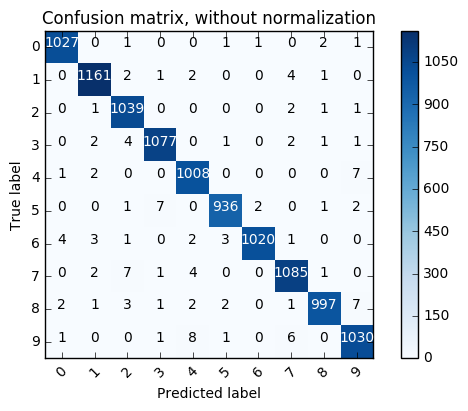

In [121]:
conf_mat = confusion_matrix(y_act, y_pred)

plt.figure()
plot_confusion_matrix(conf_mat, classes=range(10), title='Confusion matrix, without normalization')
plt.show()

The model does well, as expected from the accuracy score.  Some observations, though the statistics of errors is based on small samples:

* Some 1s are interpreted as 7s, which can be expected.
* 3s are confused with 2s a bit more often than other digits, but not vice-versa.
* 4s tend to get confused with 9s.
* 5s get confused with 3s, but not vice-versa.
* 6s get confused with 0s, 1s, and 5s.
* 7s get confused with 2s, but not vice-versa.
* 8s are confused with 9s, but not vice-versa.
* 9s are confused with 4s and 7s.  This is somewhat understandable.

We will examine a couple examples where the model was confused between 4s and 9s a bit later.

In order to compare with the features in the corresponding design matrix, x_validation, we can use the numpy where function to obtain the indices for the events where the prediction was different from the true value:

In [88]:
error_idx = np.where(y_pred != y_act)[0]

In [89]:
error_idx

array([   37,   176,   281,   342,   346,   414,   527,   832,   833,
         835,   944,   979,  1151,  1220,  1253,  1296,  1313,  1515,
        1651,  1665,  1748,  1858,  1884,  1897,  1921,  2000,  2145,
        2229,  2250,  2343,  2403,  2465,  2480,  2510,  2564,  2715,
        2750,  2826,  2996,  3034,  3062,  3069,  3081,  3127,  3248,
        3341,  3413,  3453,  3469,  3843,  4060,  4139,  4193,  4201,
        4216,  4503,  4574,  4616,  4787,  4829,  4840,  4870,  5124,
        5153,  5165,  5332,  5415,  5458,  5509,  5609,  5965,  6110,
        6148,  6248,  6274,  6319,  6418,  6491,  6575,  6577,  6735,
        6815,  7287,  7342,  7423,  7618,  7673,  7758,  7937,  8416,
        8528,  8576,  8612,  8644,  8774,  8987,  9029,  9076,  9202,
        9257,  9273,  9292,  9380,  9403,  9539,  9588,  9609,  9718,
        9925, 10232, 10238, 10290, 10326, 10383, 10390, 10413, 10422,
       10438, 10441, 10484])

We can then adapt the code from the overview notebook and display a random set of digit images from the error set:

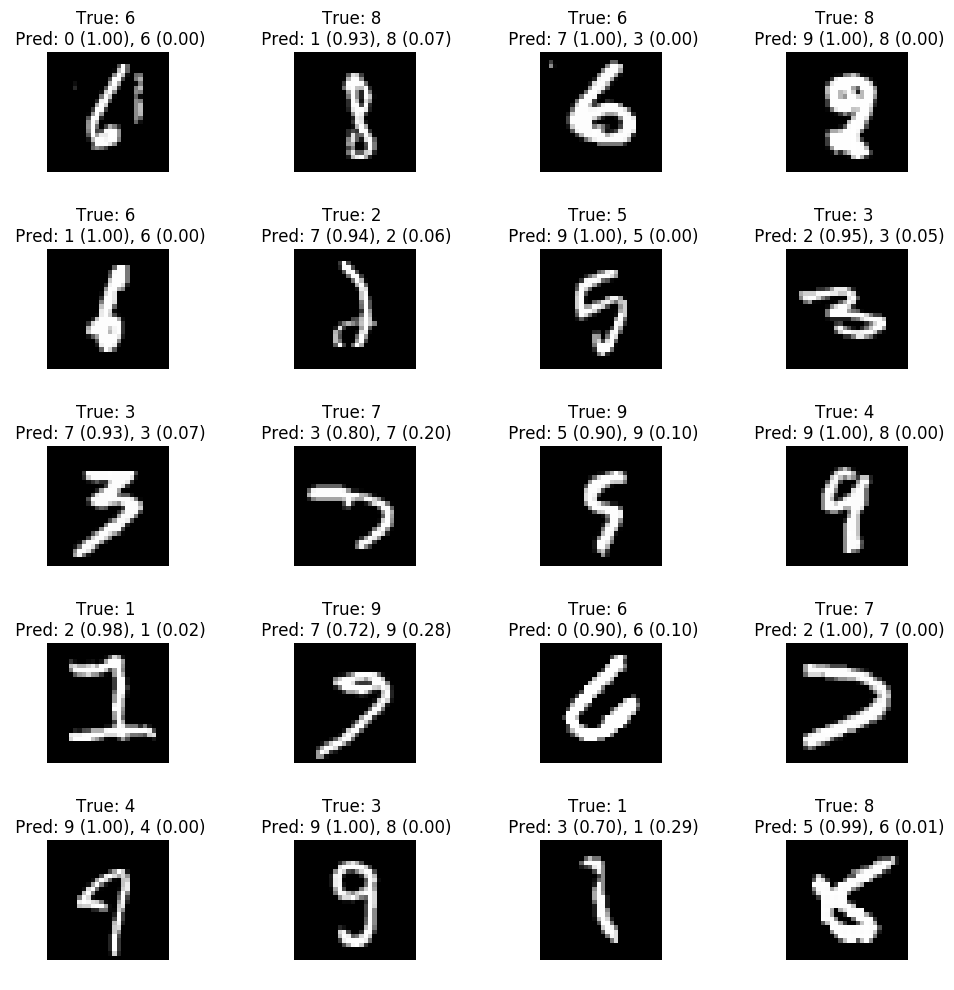

In [104]:
rand_idx = np.random.choice(error_idx, size=20, replace=False)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(10,10))

i = 0
for ax in axs.reshape(-1):
    # cycle through the elements of rand_idx
    idx = rand_idx[i]
# this is the true class label
    true_y = y_act[idx]
    # this is the vector of model class probabilities
    prob_y = y_pred_prob[idx]
    # this is the most probable class
    top_pred = np.argmax(prob_y)
    # this is probability of the top class
    prob_top = prob_y[top_pred]
    # argsort the prob. vector
    arg_sort = np.argsort(-prob_y)
    # this is the 2nd choice class 
    sec_choice = arg_sort[1]
    # this is the probability of the 2nd choice class
    prob_sec = prob_y[sec_choice]
    
    
    ax.set_title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
    ax.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    i += 1
plt.tight_layout()    
plt.show()

In [107]:
rand_idx[11]

3453

It is likely that several of these would be challenging for a human to identify with 100% accuracy, while others are quite obvious.   In some cases, it is easy to see what features that the neural network probably used to decide that the image more closely resembled a different digit than the true one.

For instance, for the following digit image, the CNN predicted "9" vs the true value of 4.

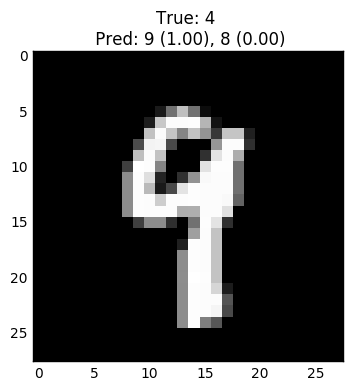

In [108]:
idx = 3453
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = y_pred_prob[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

In this case, a human might not decide that this is a 4, at least not with total confidence. The vertical stem on the right of the digit rises to a height slightly less than the loopy hook on the left. The left hook is also pronouncedly curved, very nearly meeting the right stem. Finally the lower part of the loop meets the stem at an acute angle, rather than a perpendicular.  These features are more closely associated with a 9 than a 4. In fact, the model's 2nd choice is an 8, though the human eye probably would not make that association strongly.  It turns out that 4 is the model's third choice, with a 1 in 10^6 probability assigned.

In [112]:
y_pred_prob[3453]

array([  4.44292666e-19,   1.89287613e-11,   4.34891448e-15,
         5.97060099e-15,   2.35016569e-06,   2.83814165e-15,
         7.03582122e-20,   4.47719119e-12,   3.84503983e-06,
         9.99993801e-01], dtype=float32)

For the converse identification problem, we can look at the following example:

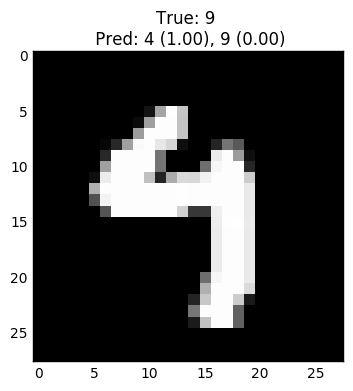

In [103]:
idx = 1253
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = y_pred_prob[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

In this case, we have a  stubby stem on the right that doesn't rise to the height of the left part of the digit.  The bottom of the loop meets the stem at almost 90 degrees, instead of the acute angle typically associated with a 9. The upper part of the loop also misses the top of the stem.  These features probably explain why the CNN thought this was a 4.  In fact 9 was the 2nd choice, though with less than 1% probability.

As an exercise, you should see if you can find similar features in other misclassified examples that could help explain why the model failed.

## Conclusions

In this notebook, we learned how to use TensorFlow to construct machine learning models using very low-level tools.  TF allows us to define models in much more detail than scikit-learn, but at the cost of requiring quite a bit of expertise about how those models work in theory and are constructed in practice.

We also learned how to apply neural networks, including the multilevel perceptron and the convolutional neural networks to the MNIST digit problem.  We saw that they lead to improvements of almost 1% in validation accuracy vs our best Random Forest result.